In [1]:
import os
from pathlib import Path


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist

In [2]:
CUR_DIR = os.path.abspath('')

DATA_DIR = Path(CUR_DIR).parent / "data"
FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df_origin = pd.read_csv(FILE_PATH, index_col = 0)

In [3]:
df_unique_values = df_origin.drop_duplicates(subset = ['song_name', 'artist_name'], keep='first').reset_index().drop('index', axis=1)
tracks_quanti_feats = df_unique_values.drop(['user', 'listening_count', 'song_name', 'release', 'artist_name',
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key', 'duration',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date'], axis = 1)

In [4]:
scaler = StandardScaler()
scaler.fit(tracks_quanti_feats)
tracks_quanti_feats[tracks_quanti_feats.columns] = pd.DataFrame(scaler.fit_transform(tracks_quanti_feats), index=tracks_quanti_feats.index)

In [6]:
tracks_quanti_feats_names = pd.DataFrame(tracks_quanti_feats)
tracks_quanti_feats_names['song_name'] = df_unique_values['song_name']
tracks_quanti_feats_names['artist_name'] = df_unique_values['artist_name']


In [7]:
scaler = StandardScaler()
sel_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df_origin[sel_columns] = pd.DataFrame(scaler.fit_transform(df_origin[sel_columns]), index=df_origin.index)

In [8]:
def get_opt_clusters(df:pd.DataFrame, drop : list[str], user_id: str):
    
    # definition of df_user
    df_user = df[df['user']==user_id].drop(drop, axis=1).reset_index().drop(['index'], axis=1)

    # weights to apply to the kmeans
    user_listenings = df_user['listening_count']

    # eliminate weights from acoustic characteristics
    df_user = df_user.drop('listening_count', axis=1) 
    

    # broad exploration of number of clusters
    dist = []
    s_scores = []
    range = np.arange(2,17)
    for i in range:
        clf = KMeans(n_clusters = i, n_init = 'auto', random_state=123)
        clf.fit(df_user, sample_weight=user_listenings)
        centroids = clf.cluster_centers_
        labels = clf.labels_
        score = silhouette_score(df_user, labels, metric='euclidean')
        s_scores.append(score)
        dist.append(sum(np.min(cdist(XA = centroids, XB = df_user, metric='euclidean'), axis = 0)) / len(df_user))
    
    # optimal number of clusters selection by silhouette score
    n_clusters = s_scores.index(max(s_scores))+2

    return range, s_scores, dist, n_clusters

In [9]:
def get_user_profiles(df: pd.DataFrame, drop : list[str],  user_id: str, n_clusters:int):
    """
    Takes a user_id string and 1 dataframe containg all original informations and whose acoustic characteristics are Standard scaled.
    Returns the acoustic characteristics of the user standard profile weighted by number of listenings (1 acoustic profile)   
    and the cluster centers centroids profiles based on Kmeans fit on optimal number of cluster found per user (n_clusters profiles)

    Parameters:
        df : whole dataframe with all acoustic characteristics Standard scaled
        user_id : str corresponding to the user id
   
    Return :
        
        standard_profile: list[list[float]] of size 1
        cluster_profile: list[list[float]] of size n_clusters
    """
    
    
    total_listening = df[df["user"] == user_id]["listening_count"].sum() 

    ## Standard profile: one profile where acoustic characteristics are weighted by listening_count
    duration = 0
    dance = 0
    energy = 0
    loudness = 0
    speech = 0
    acoustic = 0
    instru = 0
    live = 0
    valence = 0
    tempo = 0


    # cumulative sum of user's  songs acoustic characteristics weighted by listening_count
    for index, row, in df[df["user"] == user_id].iterrows():
        #duration += row['duration'] * row["listening_count"]
        dance += row['danceability'] * row["listening_count"]
        energy += row['energy'] * row["listening_count"]
        loudness += row['loudness'] * row["listening_count"]
        speech += row['speechiness'] * row["listening_count"]
        acoustic += row['acousticness'] * row["listening_count"]
        instru += row['instrumentalness'] * row["listening_count"]
        live += row['liveness'] * row["listening_count"]
        valence += row['valence'] * row["listening_count"]
        tempo += row['tempo'] * row["listening_count"]

    # duration / total_listening, 

    # weighted average from cumulative sum of acoustic characteristics / total_listening to list of lists
    standard_profile = [[dance / total_listening, energy / total_listening,
                        loudness / total_listening, speech / total_listening, acoustic / total_listening,
                        instru / total_listening, live / total_listening, valence / total_listening,
                        tempo / total_listening]]

    

    ## Cluster profile
    
    # definition of df_user
    df_user = df[df['user']==user_id].drop(drop, axis=1).reset_index().drop(['index'], axis=1)

    # weights to apply to the kmeans
    user_listenings = df_user['listening_count']

    # eliminate weights from acoustic characteristics
    df_user = df_user.drop('listening_count', axis=1) 

    # training of kmeans with optimal number of clusters
    clf = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state=123)
    clf.fit(df_user, sample_weight=user_listenings)
    centroids = clf.cluster_centers_
    labels = clf.labels_

    # distinct profiles as cluster centers centroids to list
    cluster_profile = centroids.tolist()

    
    return standard_profile, cluster_profile

Proximity measure - Numerical resolution

In [10]:
# var
acoustic_variables = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "instrumentalness", "Liveness", "Valence", "Tempo"]
n_neighbors = 5
user_name = "ec6dfcf19485cb011e0b22637075037aae34cf26"
to_drop = ['user', 'song_name', 'release', 'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss', 
           'year', 'shs_perf', 'shs_work', 'key', 'mode', 'explicit', 'time_signature', 'release_date']

# func
range_n_clusters, silhouette_scores, distorsions, n_opt_cluster = get_opt_clusters(df=df_origin, drop=to_drop, user_id=user_name)

standard_profile, clusters_profiles = get_user_profiles(df=df_origin, drop=to_drop, user_id=user_name, n_clusters=n_opt_cluster)

C:\Users\benoit\AppData\Local\Temp\ipykernel_26988\2605426301.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(121)


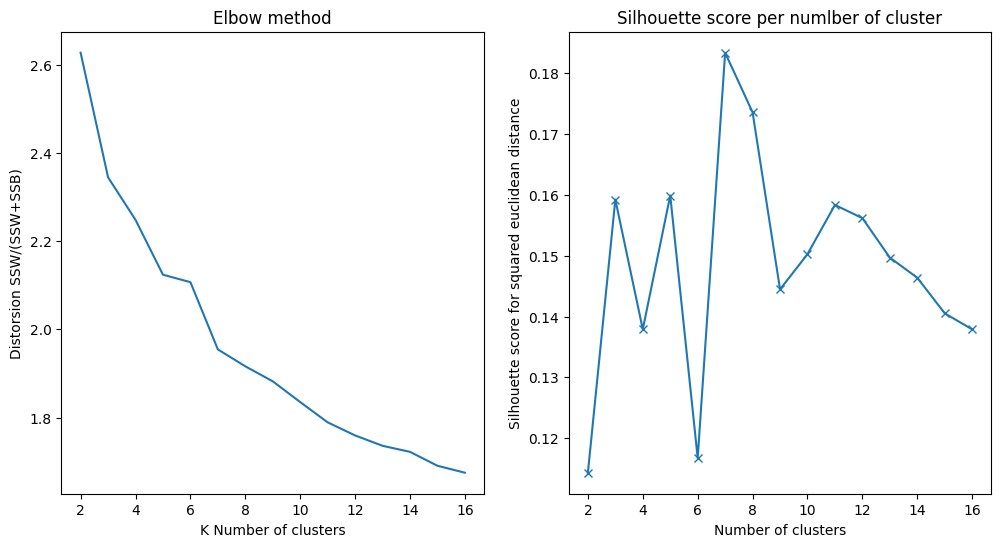

In [11]:
fig  = plt.subplots(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.plot(range_n_clusters, distorsions)
ax1.set_xlabel('K Number of clusters')
ax1.set_ylabel('Distorsion SSW/(SSW+SSB)')
ax1.set_title('Elbow method');

ax2 = plt.subplot(122)
ax2.plot(range_n_clusters, silhouette_scores, '-x')
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Silhouette score for squared euclidean distance")
ax2.set_title('Silhouette score per numlber of cluster');

In [17]:
from scipy.spatial import distance_matrix

def get_profile_neighbors(df_features, df_features_names: pd.DataFrame, profiles: list[list[float]], n_target : int = n_neighbors):
    
    user_profile = pd.DataFrame(columns=["danceability", "energy",
                                   "loudness", "speechiness", "acousticness",
                                   "instrumentalness", "liveness", "valence",
                                   "tempo"])
    

    # append profile to the dataframe user_profile
    for i in range(len(profiles)):
        user_profile.loc[len(user_profile)] = profiles[i]


    # compute the distance matrix between all user_profiles and all songs features
    dist_mat = pd.DataFrame(distance_matrix(user_profile, df_features).T)
    #dist_mat = dist_mat.rename(columns={0 : 'distance'})
    

    # create similarity and disimilarity lists
    sim = []
    dis = []
    sim_id = []
    dis_id =[]

    # broadcast distance of matrix[i] to df_features_names containing song and artist names and sort values by distance[i]
    for i in range(len(profiles)):
        df_feats_names = df_features_names
        df_feats_names[i] = dist_mat[i]
        df_feats_names = df_feats_names.sort_values(by=i, ascending=True).reset_index().drop(['index'], axis=1)
        
        # for each profile create temporary sim and disim lists
        s = []
        d = []
        s_id = []
        d_id = []

        ## append each profile list the profile closest and furthest n_neighbors tracks and corresponding song-artist names 
        for j in range (n_target):
            s.append(df_feats_names.iloc[j, :9].values.flatten().tolist())
            s_id.append(' - '.join((df_feats_names.iloc[j, 9:11])))
            
            d.append(df_feats_names.iloc[len(df_feats_names)-1-j, :9].values.flatten().tolist())
            d_id.append(' - '.join((df_feats_names.iloc[len(df_feats_names)-1-j, 9:11])))
        
        
        sim.append(s)
        sim_id.append(s_id)
        dis.append(d)
        dis_id.append(d_id)

    return sim, dis, sim_id, dis_id

In [18]:
similar, disimilar, sim_names, dis_names = get_profile_neighbors(tracks_quanti_feats, tracks_quanti_feats_names, standard_profile)
#similar, disimilar, sim_names, dis_names = get_profile_neighbors(tracks_quanti_feats, tracks_quanti_feats_names, clusters_profiles)

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


for i in range(len(similar)):

    if (len(similar) == 1):
        profile = standard_profile
        std_prof = True
        prof_name = "Standard profile weighted by listening counts"
        fig_title = f"Closest and furthest tracks from standard profile of user '{user_name}'"
        col1_title = "Closest tracks"
        col2_title = "Furthest tracks"

    elif (len(similar) > 1):
        profile = clusters_profiles    
        std_prof = False
        prof_name = f"Cluster center centroid {i+1} profile" 
        fig_title = f"Closest and furthest tracks from centroid {i+1} profile of user '{user_name}'"
        col1_title = f"Closest tracks from centroid {i+1}"
        col2_title = f"Furthest tracks from centroid {i+1}"

    
    fig = make_subplots(rows=n_neighbors, cols=2,
                        shared_xaxes='columns', shared_yaxes='columns',
                        vertical_spacing = 0.1,
                        horizontal_spacing=0,
                        #column_titles = ["Closest tracks", "Furthest tracks"],
                        #row_heights = [0.9,0.9],
                        #subplot_titles=(),
                     specs = [[{'type': 'polar'}]*2]*n_neighbors)


    trace_profile = go.Scatterpolar(r = profile[i],
                                             theta = acoustic_variables,
                                             mode = "lines+markers", line_color='#636EFA',
                                             
                                                                                          
                                             name = prof_name)

    #https://community.plotly.com/t/plotly-colours-list/11730/3
    colors_col2 = ['orange', '#8c564b', '#7f7f7f', '#2ca02c', 'pink' ]


    for j in range(len(similar[i])):
        fig.add_trace(trace_profile, row=j+1, col=1)

        fig.add_trace(go.Scatterpolar(
            r = similar[i][j],
            name = f"Closest track rank {j+1}",
            theta = acoustic_variables,
            #text=["Foundbird - Papercuts"],
            #textposition="top center"
        ), row=j+1, col=1)

        fig.add_trace(trace_profile, row=j+1, col=2)

        fig.add_trace(go.Scatterpolar(
            r = disimilar[i][j],
            name = f"Furthest track rank {j+1}",
            theta = acoustic_variables,
            line_color = colors_col2[j],
            #text=["Foundbird - Papercuts"],
            #textposition="top center"
        ), row=j+1, col=2)

    fig.add_annotation(x= 0.14, y = 1.07,
                       text = col1_title,
                       showarrow=False,
                       font = dict(color="black",
                                   size=20))


    fig.add_annotation(x= 0.86, y = 1.07,
                       text = col2_title,
                       showarrow=False,
                       font = dict(color="black",
                                   size=20))

    fig.update_traces(fill='toself')#,
                      #mode = "lines+markers", line_color='indianred',
                      #marker =   dict(color='lightslategray', size=8, symbol='square'))

    fig.update_layout(
    height = 1600,
    width = 1600,
    #title_text = "Test",
    title= dict(text=fig_title,
                x=0.5,
                y=0.99,
                #x_anchor = 'center',
                #y_anchor = 'top', 
                font = dict(
                    #family = 'Courier New')
                    size = 24)),
    margin=dict(l=50, r=50, t=200, b=50),
    #paper_bgcolor="LightSteelBlue",
    polar = dict(radialaxis = dict(showticklabels=False, ticks='')), #radialaxis_range = [-10,10]),
                 #angularaxis = dict(showticklabels=False, ticks='')                
    showlegend=True
    )


    #https://plotly.com/python/reference/layout/polar/
    fig.update_polars(
        radialaxis_showticklabels = False
    )

    names = set()
    fig.for_each_trace(
        lambda trace:
            trace.update(showlegend=False)
            if (trace.name in names) else names.add(trace.name))

    fig.show()
